# Xây dựng cây quyết định và rừng cây

## 1.Tải thư viện 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

## 2. Nạp dữ liệu huấn luyện

In [2]:

df = pd.read_csv('data/train.csv')
print("Tải dữ liệu thành công!")
print("Xem qua vài dòng đầu:")
print(df.head())
print("\nThông tin chung:")
df.info()


Tải dữ liệu thành công!
Xem qua vài dòng đầu:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0 

## 3. Tiền xử lý dữ liệu và Chọn đặc trưng

### 3a. Xác định biến mục tiêu và loại bỏ cột không cần thiết:

In [3]:
# Loại bỏ các cột không cần thiết
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
print("\nDataFrame sau khi loại bỏ cột không cần thiết:")
print(df.head())


DataFrame sau khi loại bỏ cột không cần thiết:
   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S


### 3b. Xử lý giá trị bị thiếu (Missing Values):

In [4]:
print("\nSố lượng giá trị thiếu trước khi xử lý:")
print(df.isnull().sum())

# Điền giá trị thiếu cho Age bằng trung vị
df['Age'].fillna(df['Age'].median(), inplace=True)

# Điền giá trị thiếu cho Embarked bằng mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

print("\nSố lượng giá trị thiếu sau khi xử lý:")
print(df.isnull().sum())


Số lượng giá trị thiếu trước khi xử lý:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Số lượng giá trị thiếu sau khi xử lý:
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


C:\Users\84794\AppData\Local\Temp\ipykernel_25788\3080984869.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
C:\Users\84794\AppData\Local\Temp\ipykernel_25788\3080984869.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

### 3c. Chuyển đổi dữ liệu hạng mục (Categorical):

In [5]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)
print("\nDataFrame sau khi chuyển đổi dữ liệu hạng mục:")
print(df.head())

print("\nTên các cột sau khi xử lý:")
print(df.columns)


DataFrame sau khi chuyển đổi dữ liệu hạng mục:
   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False       False   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  

Tên các cột sau khi xử lý:
Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


### 3d. Xác định danh sách đặc trưng (features) và tách X, y:

In [6]:
# Cập nhật danh sách này dựa trên tên cột thực tế sau bước 3c
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_Q', 'Embarked_S']
# Kiểm tra lại xem các tên cột này có tồn tại trong df.columns không
existing_features = [col for col in features if col in df.columns]

if len(existing_features) != len(features):
    print("\nCảnh báo: Một số features dự định không tồn tại sau get_dummies.")
    print("Features sẽ sử dụng:", existing_features)
    features = existing_features # Chỉ dùng các features thực sự có

X = df[features].values
y = df['Survived'].values

print(f"\nKích thước ma trận X: {X.shape}")
print(f"Kích thước vector y: {y.shape}")


Kích thước ma trận X: (891, 8)
Kích thước vector y: (891,)


## 4. Chia dữ liệu thành tập huấn luyện và tập kiểm thử

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
print(f"\nKích thước X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"Kích thước y_train: {y_train.shape}, y_test: {y_test.shape}")


Kích thước X_train: (712, 8), X_test: (179, 8)
Kích thước y_train: (712,), y_test: (179,)


## 5. Xây dựng cây quyết định

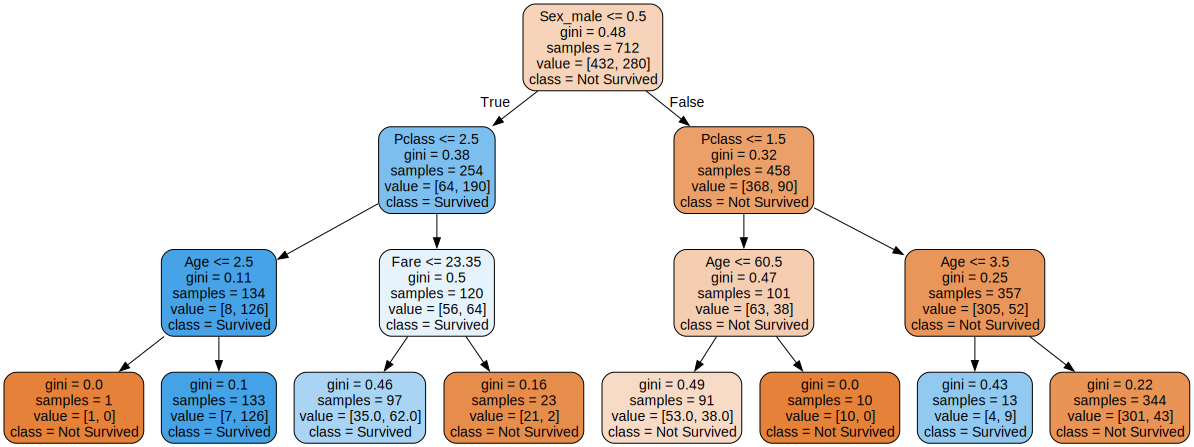

In [8]:
# Tạo và huấn luyện mô hình
dt_titanic = tree.DecisionTreeClassifier(max_depth=3) # Bạn có thể thử độ sâu khác
dt_titanic.fit(X_train, y_train)

# Trực quan hóa cây
dot_data_titanic = tree.export_graphviz(dt_titanic,
                                        out_file=None,
                                        filled=True,
                                        rounded=True,
                                        feature_names=features, # Danh sách features đã xác định
                                        proportion=False, # Hiển thị số lượng thay vì tỉ lệ
                                        class_names=['Not Survived', 'Survived'], # Tên lớp
                                        precision=2) # Số chữ số thập phân
graph_titanic = graphviz.Source(dot_data_titanic)
graph_titanic


## 6. Tìm tham số tối ưu cho cây quyết định

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Tham số max_depth tốt nhất cho Cây Quyết Định: {'max_depth': 3}
Điểm ROC AUC tốt nhất trên tập validation: 0.8356


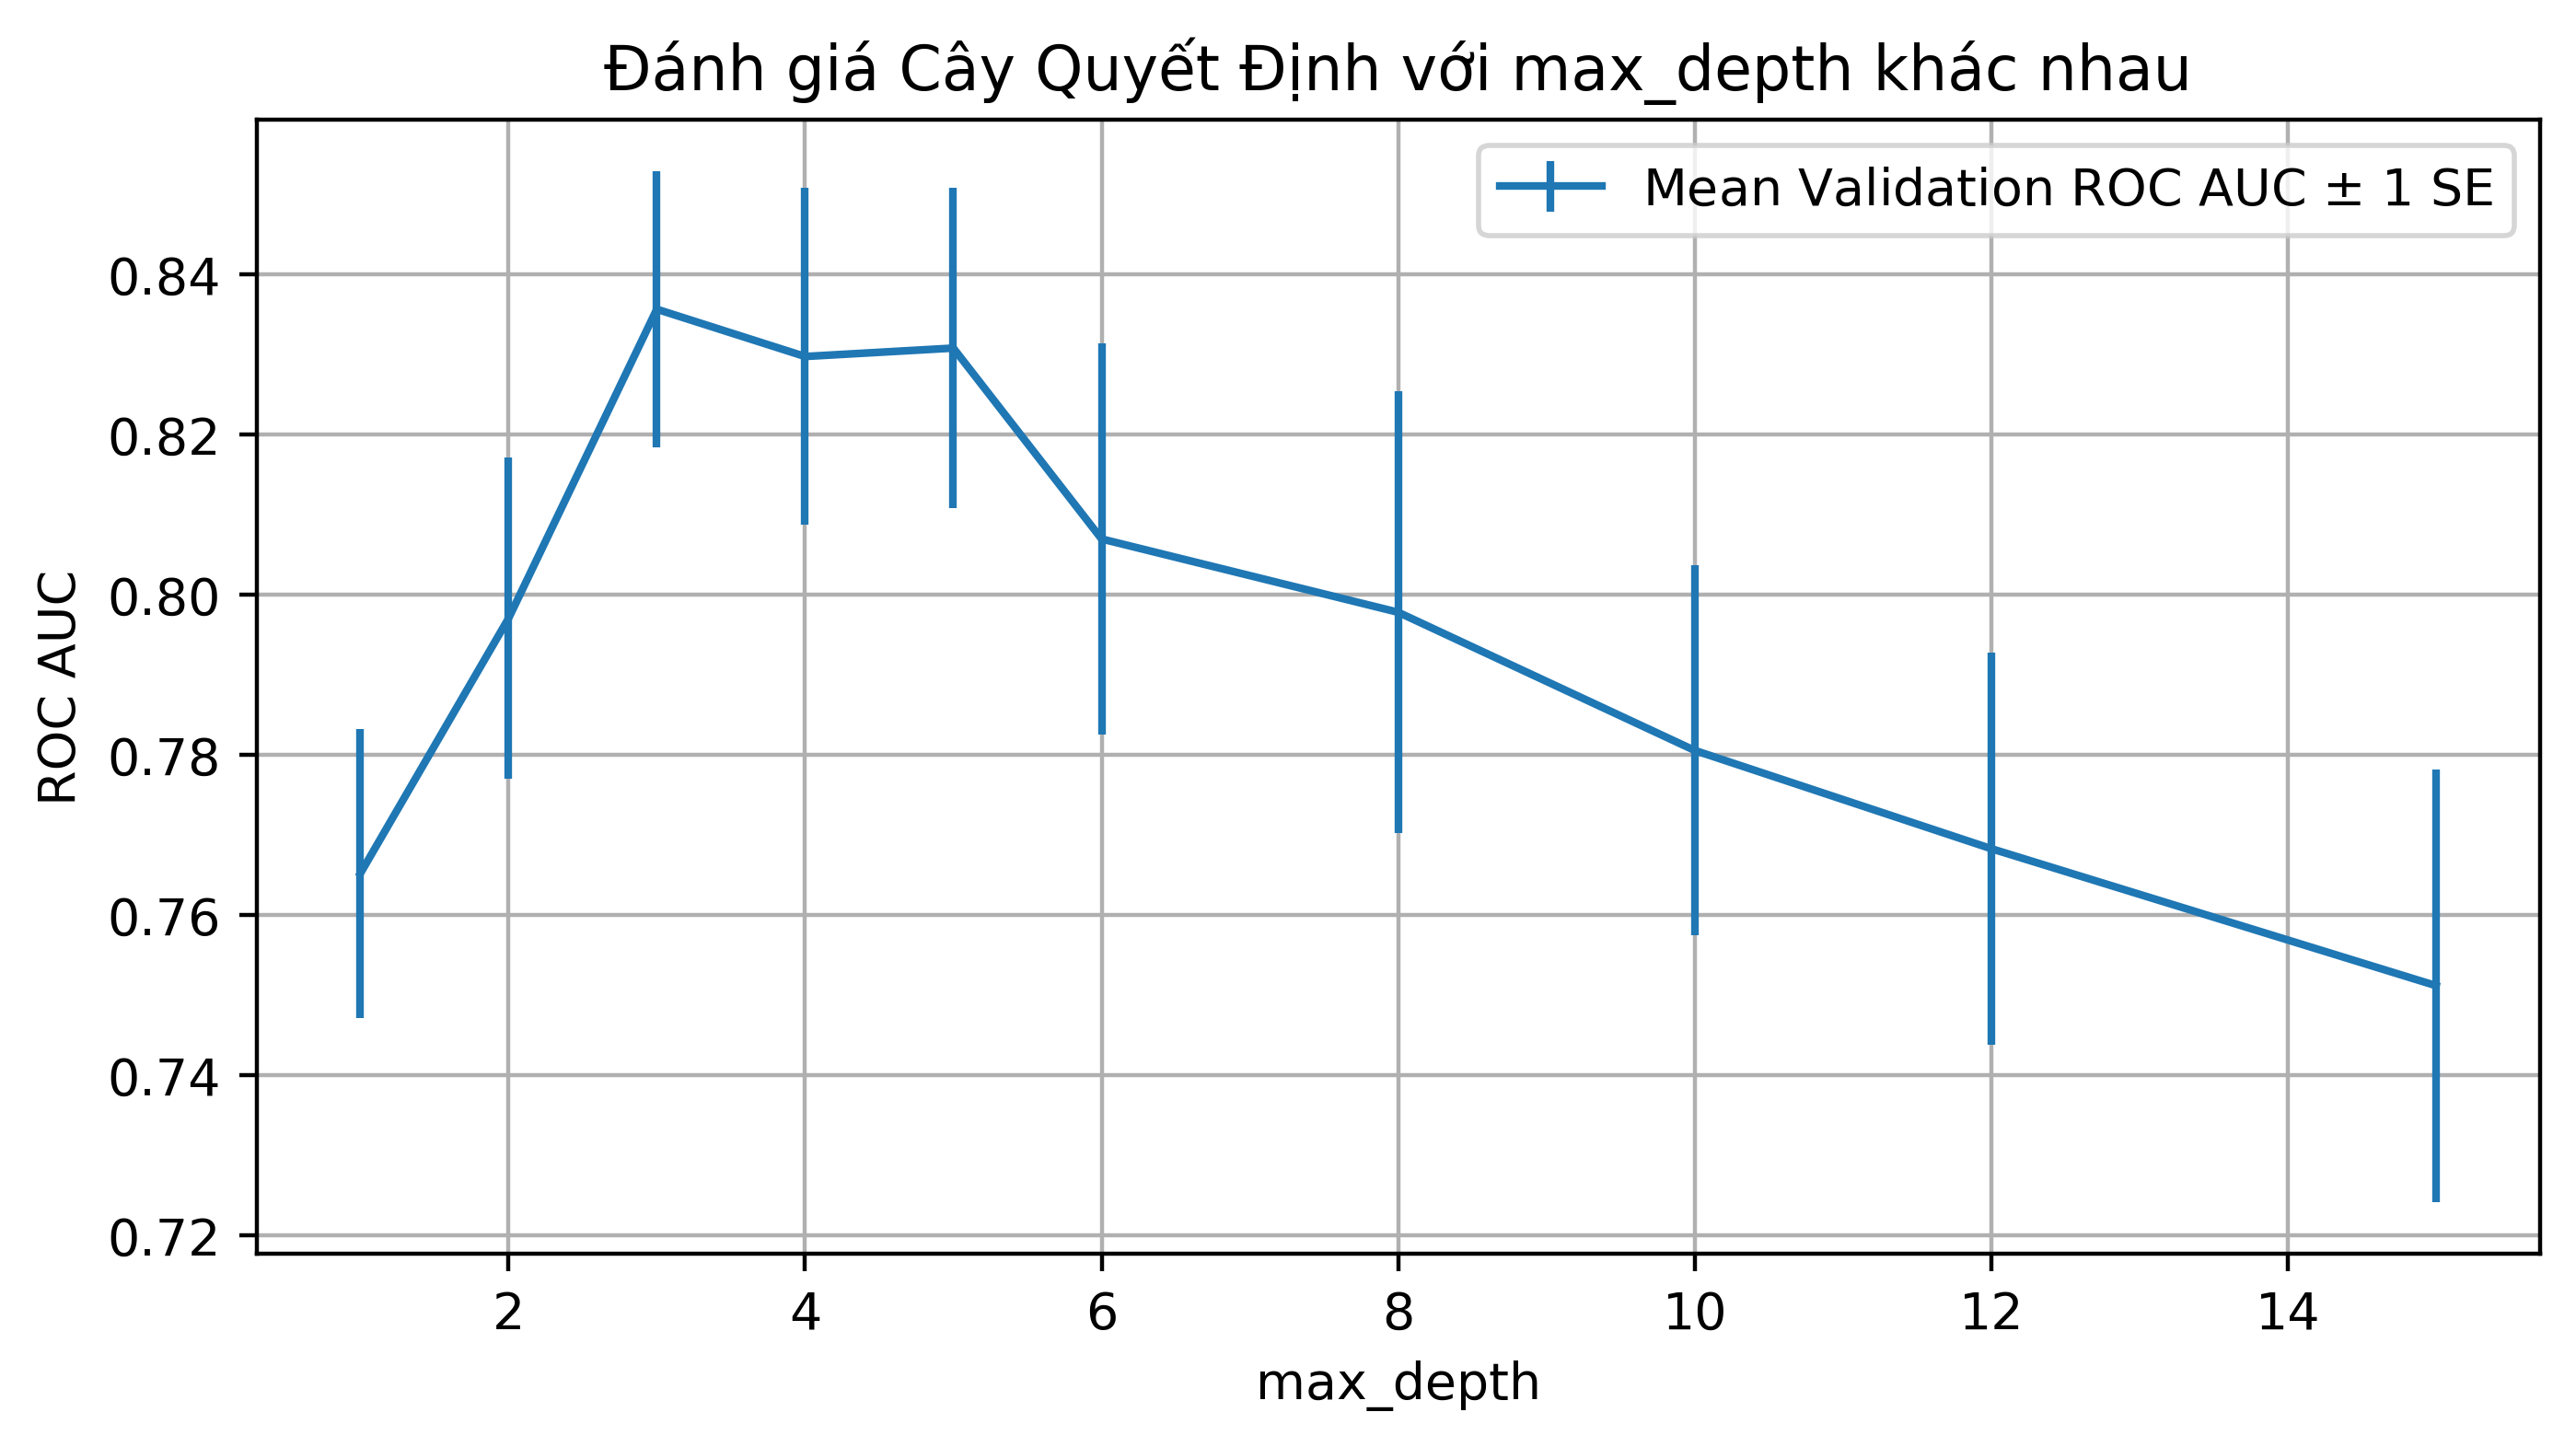

In [9]:
# Định nghĩa không gian tham số cần tìm kiếm
params_dt = {'max_depth': [1, 2, 3, 4, 5, 6, 8, 10, 12, 15]}

# Tạo đối tượng GridSearchCV
cv_dt_titanic = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), # Thêm random_state để kết quả ổn định
                             param_grid=params_dt,
                             scoring='roc_auc', # Hoặc 'accuracy', 'f1', ...
                             cv=5, # Sử dụng 5-fold cross-validation
                             verbose=1,
                             return_train_score=True)

# Huấn luyện
cv_dt_titanic.fit(X_train, y_train)

print(f"\nTham số max_depth tốt nhất cho Cây Quyết Định: {cv_dt_titanic.best_params_}")
print(f"Điểm ROC AUC tốt nhất trên tập validation: {cv_dt_titanic.best_score_:.4f}")

# Vẽ biểu đồ đánh giá (tương tự như trong notebook gốc)
cv_results_dt_df = pd.DataFrame(cv_dt_titanic.cv_results_)

plt.figure(figsize=(8, 4))
plt.errorbar(cv_results_dt_df['param_max_depth'],
             cv_results_dt_df['mean_test_score'],
             yerr=cv_results_dt_df['std_test_score'] / np.sqrt(cv_dt_titanic.cv), # Lấy số fold từ cv
             label='Mean Validation ROC AUC $\\pm$ 1 SE')
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')
plt.title('Đánh giá Cây Quyết Định với max_depth khác nhau')
plt.legend()
plt.grid(True)
plt.show()

## 7. Xây dựng Rừng Ngẫu Nhiên

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Tham số n_estimators tốt nhất cho Rừng Ngẫu Nhiên: {'n_estimators': 120}
Điểm ROC AUC tốt nhất trên tập validation: 0.8668


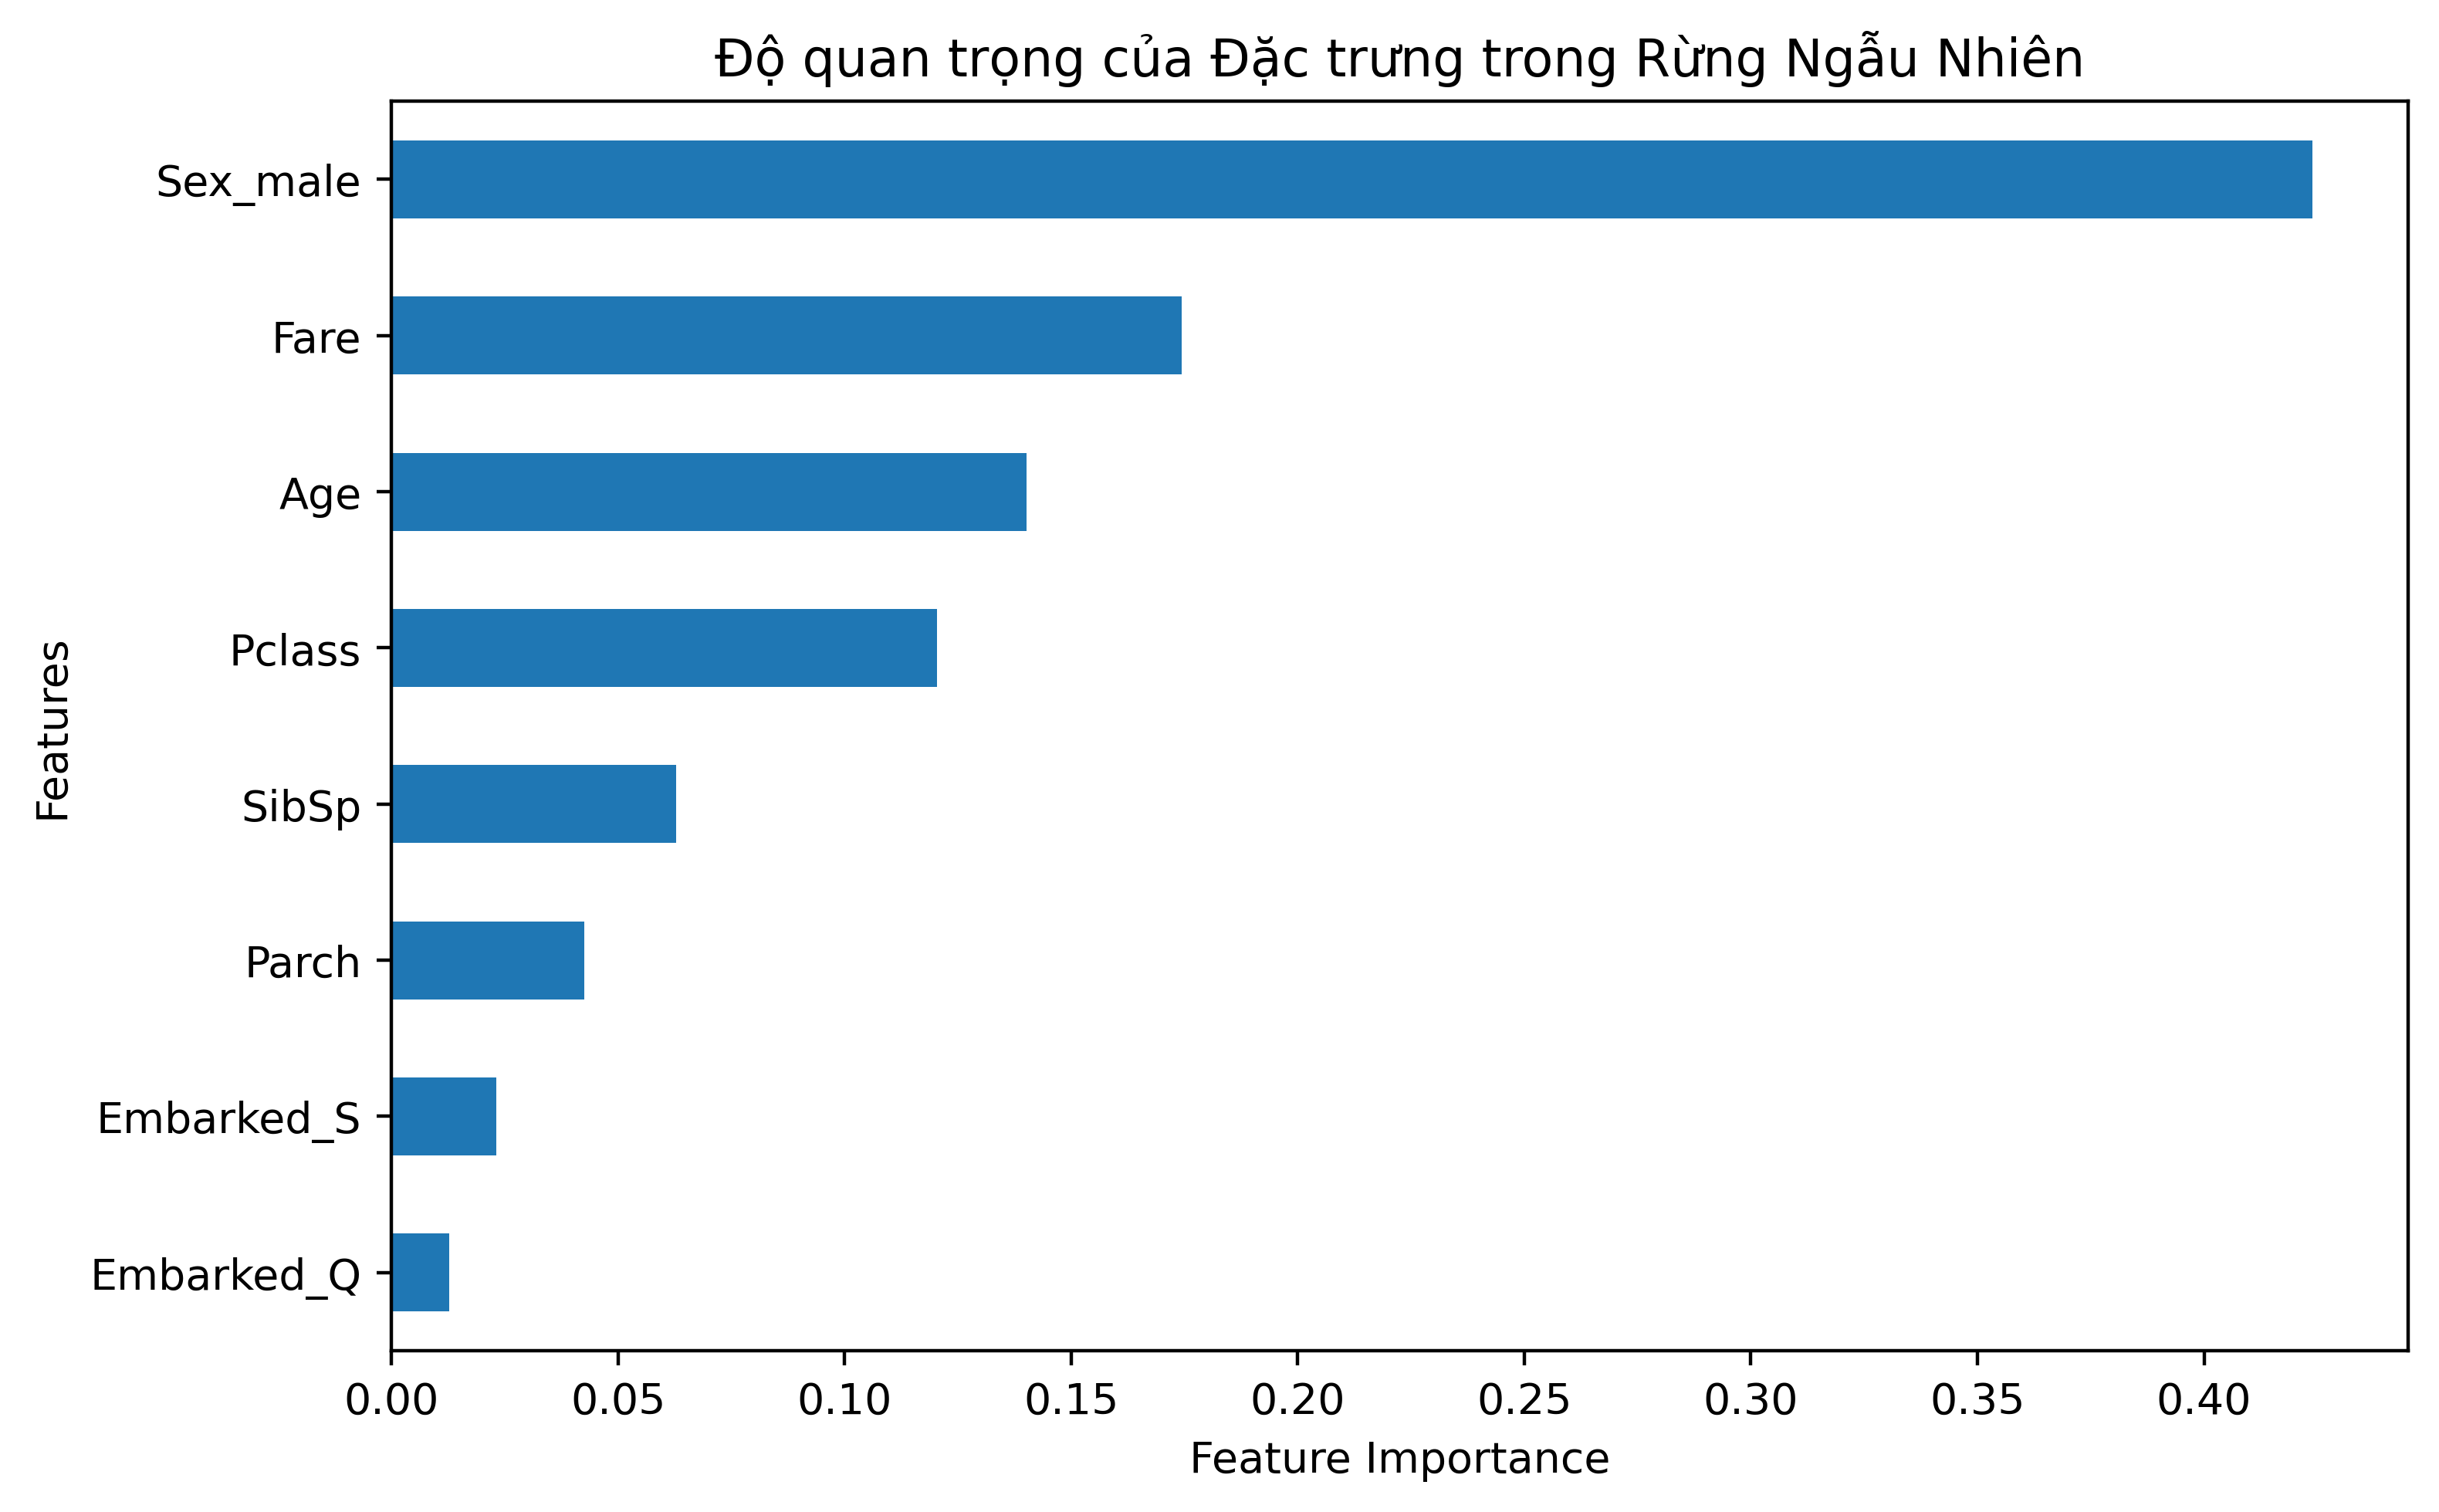

In [10]:
# Tạo mô hình Random Forest cơ sở
rf_titanic = RandomForestClassifier(max_depth=6, # Sử dụng max_depth tốt nhất từ Task 2 hoặc một giá trị khác
                                    random_state=42)

# Định nghĩa không gian tham số (số lượng cây)
params_rf = {'n_estimators': list(range(10, 151, 10))} # Thử từ 10 đến 150 cây

# Tạo đối tượng GridSearchCV
cv_rf_titanic = GridSearchCV(rf_titanic,
                             param_grid=params_rf,
                             scoring='roc_auc',
                             cv=5,
                             verbose=1,
                             return_train_score=True)

# Huấn luyện
cv_rf_titanic.fit(X_train, y_train)

print(f"\nTham số n_estimators tốt nhất cho Rừng Ngẫu Nhiên: {cv_rf_titanic.best_params_}")
print(f"Điểm ROC AUC tốt nhất trên tập validation: {cv_rf_titanic.best_score_:.4f}")

# Lấy mô hình tốt nhất
best_rf_titanic = cv_rf_titanic.best_estimator_

# Xem độ quan trọng của đặc trưng
feat_imp_rf_df = pd.DataFrame({
    'Importance': best_rf_titanic.feature_importances_
}, index=features)

# Vẽ biểu đồ độ quan trọng
plt.figure(figsize=(8, 5))
feat_imp_rf_df.sort_values('Importance', ascending=True).plot(kind='barh', legend=False, ax=plt.gca())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Độ quan trọng của Đặc trưng trong Rừng Ngẫu Nhiên')
plt.tight_layout()
plt.show()